In [204]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
import numpy as np
from numpy.lib import stride_tricks
import cv2
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)

Populating the interactive namespace from numpy and matplotlib


In [381]:
class PatchMatch(object):
    def __init__(self, a, b, patch_size):
        assert a.shape == b.shape, "Dimensions were unequal for patch-matching input"
        self.A = a
        self.B = b
        self.patch_size = patch_size
        self.nnf = np.zeros(shape=(2, self.A.shape[0], self.A.shape[1])).astype(np.int)
        self.nnd = np.zeros(shape=(self.A.shape[0], self.A.shape[1]))
        self.initialise_nnf()
    
    def initialise_nnf(self):
        self.nnf[0] = np.random.randint(self.B.shape[1], size=(self.A.shape[0], self.A.shape[1]))
        self.nnf[1] = np.random.randint(self.B.shape[0], size=(self.A.shape[0], self.A.shape[1]))
        self.nnf = self.nnf.transpose((1, 2 ,0))
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                pos = self.nnf[i,j]
                self.nnd[i,j] = self.cal_dist(i, j, pos[1], pos[0])

    def cal_dist(self, ai ,aj, bi, bj):
        dx0 = dy0 = self.patch_size//2
        dx1 = dy1 = self.patch_size//2 + 1
        dx0 = min(ai, bi, dx0)
        dx1 = min(self.A.shape[0]-ai, self.B.shape[0]-bi, dx1)
        dy0 = min(aj, bj, dy0)
        dy1 = min(self.A.shape[1]-aj, self.B.shape[1]-bj, dy1)
        if (dx1+dx0) * (dy1+dy0) == 0:
            print("Zero")
        return np.sum((self.A[ai-dx0:ai+dx1, aj-dy0:aj+dy1]-self.B[bi-dx0:bi+dx1, bj-dy0:bj+dy1])**2) / ((dx1+dx0) * (dy1+dy0))
#   //l2 distance between two patches
# float dist(int ***a, int ***b, int ax, int ay, int bx, int by,int a_rows, int a_cols, int b_rows, int b_cols, float cutoff = INT_MAX) {
# 	float ans = 0, num = 0;
# 	for (int dy = -patch_w/2; dy <= patch_w/2; dy++) {
# 		for (int dx = -patch_w/2; dx <= patch_w/2; dx++) {
# 			if (
# 				(ay + dy) < a_rows && (ay + dy) >= 0 && (ax + dx) < a_cols && (ax + dx) >= 0
# 				&&
# 				(by + dy) < b_rows && (by + dy) >= 0 && (bx + dx) < b_cols && (bx + dx) >= 0
# 				)//the pixel in a should exist and pixel in b should exist
# 			{
# 				int dr = a[ay + dy][ax + dx][2] - b[by + dy][bx + dx][2];
# 				int dg = a[ay + dy][ax + dx][1] - b[by + dy][bx + dx][1];
# 				int db = a[ay + dy][ax + dx][0] - b[by + dy][bx + dx][0];
# 				ans += dr*dr + dg*dg + db*db;
# 				num += 1;
# 			}
			
# 		}
		
# 	}
# 	ans = ans / num;
# 	if (ans >= cutoff) { return cutoff; }
# 	else {
# 		return ans;
# 	}
# }
#     def cal_dist(self,ay,ax,by,bx):
#         ans = 0
#         num = 0
#         a_rows = self.A.shape[0]
#         a_cols = self.A.shape[1]
        
#         b_rows = self.A.shape[0]
#         b_cols = self.A.shape[1]

#         dy = -self.patch_size//2
#         while dy<= self.patch_size//2:
            
#             dx = -self.patch_size//2
#             while dx<= self.patch_size//2:
#                 if (ay + dy) < a_rows and (ay + dy) >= 0 and (ax + dx) < a_cols and (ax + dx) >= 0:
#                     if (by + dy) < b_rows and (by + dy) >= 0 and (bx + dx) < b_cols and (bx + dx) >= 0:
#                         dr = int(int(self.A[ay + dy][ax + dx][2]) - int(self.B[by + dy][bx + dx][2])    )
#                         dg = int(int(self.A[ay + dy][ax + dx][1]) - int(self.B[by + dy][bx + dx][1]) )
#                         db = int(int(self.A[ay + dy][ax + dx][0]) - int(self.B[by + dy][bx + dx][0]))
#                         ans += (int(int(dr*dr) + int(dg*dg) + int(db*db)))
#                         num += 1
#                 dx +=1
#             dy+=1
#         try:
#             ans = ans/num
#         except :
#             print(ax)
#             print(ay)
#             print(bx)
#             print(by)
#         return ans

    
    def reconstruct(self):
        ans = np.zeros_like(self.A)
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                pos = self.nnf[i,j]
                ans[i,j] = self.B[pos[1], pos[0]]
        return ans
    
    def reconstruct_img_voting(self, patch_size=3,arr_v=None):
        if patch_size is None:
            patch_size = self.patch_size
        b_prime = np.zeros_like(self.A,dtype=np.uint8)

        for i in range(self.A.shape[0]): #traverse down a
            for j in range(self.A.shape[1]): #traverse across a
                
                dx0 = dy0 = patch_size//2
                dx1 = dy1 = patch_size//2 + 1
                dx0 = min(i,dx0)
                dx1 = min(self.A.shape[0]-i, dx1)
                dy0 = min(j, dy0)
                dy1 = min(self.A.shape[1]-j, dy1)
                
                votes = self.nnf[i-dx0:i+dx1, j-dy0:j+dy1] 
                b_patch = np.zeros(shape=(votes.shape[0],votes.shape[1],self.A.shape[2]))
                
                for p_i in range(votes.shape[0]):
                    for p_j in range(votes.shape[1]):
                     
                        b_patch[p_i, p_j] = self.B[votes[p_i,p_j][0] , votes[p_i,p_j][1]]

                averaged_patch = np.average(b_patch,axis=(0,1))
                b_prime[i, j] = averaged_patch[:]
        plt.imshow(b_prime[:,:,::-1])
        plt.show()
        
    def visualize(self):
        nnf = self.nnf
        nnd = self.nnd
        img = np.zeros((nnf.shape[0], nnf.shape[1], 3),dtype=np.uint8)


        for i in range(1, nnf.shape[0]):
            for j in range(1, nnf.shape[1]):
                pos = nnf[i,j]
                img[i, j, 0] = int(255 * (pos[0]/self.B.shape[1]))
                img[i, j, 1] = int(255 * (pos[1]/self.B.shape[0]))
                
        return img


    
    def visualize_nnf(self):
        nnf = self.nnf
        nnd = self.nnd
        def angle_between_alt(p1, p2):
            ang1 = np.arctan2(*p1[::-1])
            ang2 = np.arctan2(*p2[::-1])
            return np.rad2deg((ang1 - ang2) % (2 * np.pi))

        def norm_dist(arr):
            return (arr)/(arr.max())
    
        img = np.zeros((nnf.shape[0], nnf.shape[1], 3),dtype=np.uint8)
        for i in range(1, nnf.shape[0]):
            for j in range(1, nnf.shape[1]):
                angle = angle_between_alt([j, i], [nnf[i, j][0], nnf[i, j][1]])
                img[i, j, :] = np.array([angle, nnd[i,j], 250])
        img = hsv_to_rgb(norm_dist(img/255))
        plt.imshow(img)
        plt.show()
    
    def propagate(self,iters=2):
        a_cols = self.A.shape[1]
        a_rows = self.A.shape[0]

        b_cols = self.B.shape[1]
        b_rows = self.B.shape[0]

        for it in range(iters):
            ystart = 0
            yend = a_rows
            ychange = 1
            xstart = 0
            xend = a_cols
            xchange = 1;
            
            if it % 2 == 1 :
                xstart = xend - 1 
                xend = -1
                xchange = -1
                ystart = yend - 1
                yend = -1; ychange = -1;
                
            ay = ystart
            while ay!=yend:
            
                ax = xstart
                while ax!=xend:

                    xbest,ybest = self.nnf[ay,ax]
                    dbest = self.nnd[ay,ax]
                    
                    if ax - xchange <0:
                        print("LESS THAN 0")

                    if ax -xchange < a_cols and ax-xchange >=0:
                        vp = self.nnf[ay,ax-xchange]
                        xp = vp[0] + xchange
                        yp = vp[1] 
                        if xp < b_cols:
                            val = self.cal_dist(ay, ax, yp, xp)
                            if val < dbest:
                                xbest, ybest, dbest = xp, yp, val
                                
#                     if abs(ay - ychange) < a_rows  and ay - ychange >=0:
#                         vp = self.nnf[ay-ychange,ax]
#                         xp = vp[0]
#                         yp = vp[1]+ychange
#                         if yp < b_rows:
#                             val = self.cal_dist(ay, ax, yp, xp)
#                             if val < dbest:
#                                 xbest, ybest, dbest = xp, yp, val
                                
#                     rand_d = max(self.B.shape[0], self.B.shape[1])
#                     while rand_d >= 1:
#                         try:
#                             xmin = max(xbest - rand_d, 0)
#                             xmax = min(xbest + rand_d, b_cols)
                            
#                             ymin = max(ybest - rand_d, 0)
#                             ymax = min(ybest + rand_d, b_rows)
                            
#                             if xmin < xmax and ymin < ymax:
#                                 rx = np.random.randint(xmin, xmax)
#                                 ry = np.random.randint(ymin, ymax)

#                                 val = self.cal_dist(ay, ax ,ry, rx)
#                                 if val < dbest:
#                                     xbest, ybest, dbest = rx, ry, val
                                
#                         except Exception as e:
#                             print(e)
#                             print(rand_d)
#                             print(xmin, xmax)
#                             print(ymin, ymax)
#                             print(bestx, besty)
#                             print(self.B.shape)
                            
#                         rand_d = rand_d // 2
                        
                    self.nnf[ay, ax] = [xbest, ybest]
                    self.nnd[ay, ax] = dbest
                  
                    ax+=xchange
                ay+=ychange
            

                
        print("Done")

(200, 200, 3)


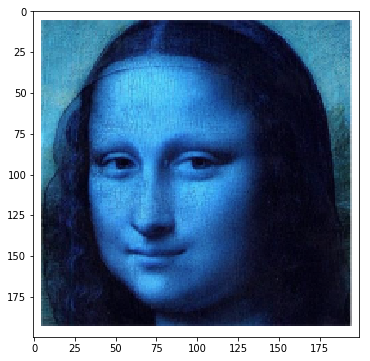

In [382]:
x = cv2.imread("./mona.png")
y = cv2.imread("./ava.png")

x = cv2.resize(x,(200,200))
y = cv2.resize(y,(200,200))
plt.imshow(x)
print(x.shape)

In [383]:
pm = PatchMatch(x,y, 3)
# pm.visualize_nnf()
# plt.imshow(pm.visualize())

LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS

/home/harsh/ml/Deep-Image-Analogy/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
Zero
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 0
LESS THAN 

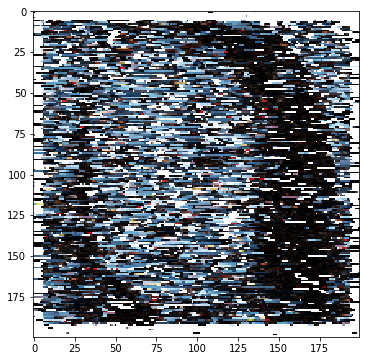

In [384]:
def do():
    pm.propagate(iters=5)
    plt.imshow(pm.reconstruct()[:,:,::-1])
    plt.show()
#     pm.reconstruct_img_voting(patch_size=3)
#     pm.propagate()
#     pm.reconstruct_img_voting(patch_size=3)
#     pm.propagate()
#     pm.reconstruct_img_voting(patch_size=3)
#     pm.propagate()
#     pm.reconstruct_img_voting(patch_size=3)

do()

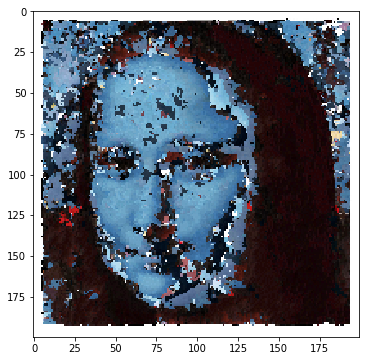

In [360]:
plt.imshow(pm.reconstruct()[:,:,::-1])





# pm.visualize_nnf()

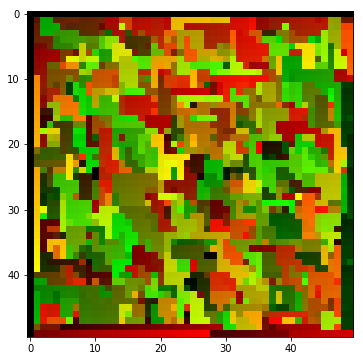

In [248]:
plt.imshow(pm.visualize())

# do()

In [ ]:
plt.figure(1)
plt.subplot(131)
plt.axis('off')
plt.imshow(x[:,:,::-1])

plt.subplot(132)
plt.axis('off')
plt.imshow(y[:,:,::-1])

plt.subplot(133)
plt.axis('off')
plt.imshow(pm.reconstruct()[:,:,::-1])

plt.show()

In [ ]:
import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(src_dir)

In [ ]:
os.path.join(os.getcwd(), os.pardir)

In [ ]:
from src.PatchMatch import PatchMatchSimple

In [ ]:
pm = PatchMatchSimple(x,y,patch_size=3)
for i in range(15):
    pm.propagate()
    pm.reconstruct_img_voting(patch_size=3)

In [ ]:
pm.visualize_nnf()

In [238]:
0/0

ZeroDivisionError: division by zero